In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import norm, skew
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
sns.set(font='SimHei')  # 解决Seaborn中文显示问题

In [40]:
#读取数据


train_df= pd.read_csv('E:train.csv',index_col=0)
test_df = pd.read_csv('E:test.csv',index_col=0)

In [4]:
#查看数据集中是否有缺失值
print(train_df.isnull().sum())

时间               0
小区名              0
小区房屋出租数量      1001
楼层               0
总楼层              0
房屋面积             0
房屋朝向             0
居住状态        176401
卧室数量             0
厅的数量             0
卫的数量             0
出租方式        172309
区               31
位置              31
地铁线路        104761
地铁站点        104761
距离          104761
装修情况        178047
月租金              0
dtype: int64


count    196539.000000
mean          7.949313
std           6.310609
min           0.000000
25%           4.923599
50%           6.621392
75%           8.998302
max         100.000000
Name: 月租金, dtype: float64


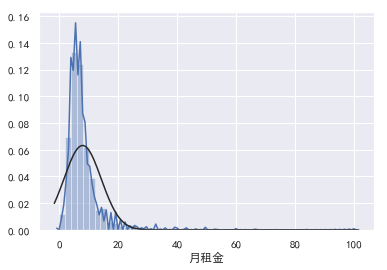

In [5]:
print(train_df.月租金.describe()) # 打印价格统计
sns.distplot(train_df.月租金, fit=norm) # 画价格分布直方图



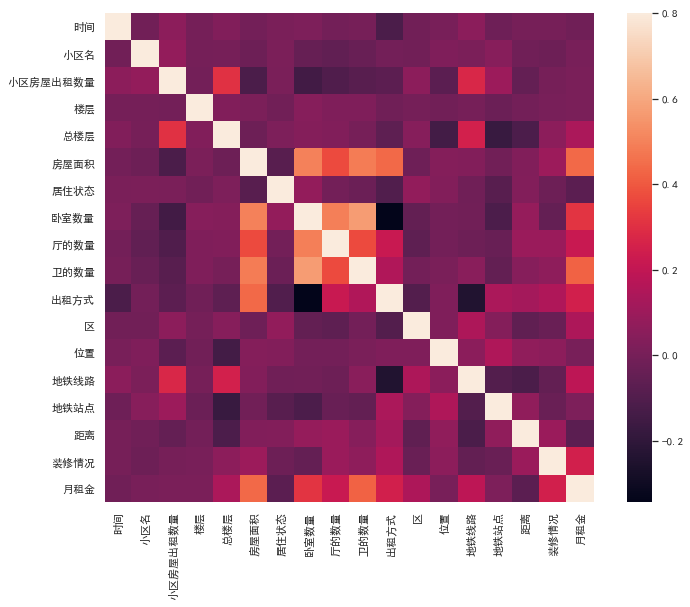

In [6]:
#计算相关性
corrmat = train_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

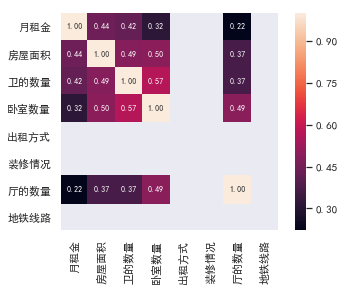

In [7]:
k = 8
cols = corrmat.nlargest(k, '月租金')['月租金'].index # 选出和月租金相关系数最大的8个特征（包含SalePrice）
cm = np.corrcoef(train_df[cols].values.T)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': k}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

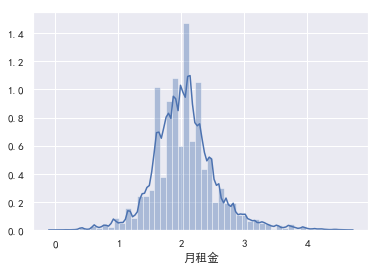

In [8]:
#使用对数函数log1p使他看起来像正态分布
y_train = np.log1p(train_df.pop('月租金'))
sns.distplot(y_train)

In [9]:
train_df.drop ('装修情况', axis=1,inplace=True)
train_df.drop ('居住状态', axis=1,inplace=True)
train_df.drop ('出租方式', axis=1,inplace=True)
train_df.drop ('时间', axis=1,inplace=True)
train_df.drop ('地铁站点', axis=1,inplace=True)
train_df.drop ('地铁线路', axis=1,inplace=True)
train_df.drop ('房屋朝向', axis=1,inplace=True)
train_df.drop ('距离', axis=1,inplace=True)

In [10]:
test_df.drop ('装修情况', axis=1,inplace=True)
test_df.drop ('居住状态', axis=1,inplace=True)
test_df.drop ('出租方式', axis=1,inplace=True)
test_df.drop ('时间', axis=1,inplace=True)
test_df.drop ('地铁站点', axis=1,inplace=True)
test_df.drop ('地铁线路', axis=1,inplace=True)
test_df.drop ('房屋朝向', axis=1,inplace=True)
test_df.drop ('距离', axis=1,inplace=True)

In [11]:
#打印train中每个特征的空值率和空值数
def calc_null(data):
    total= data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
    print(missing_data.head(20))
    
calc_null(train_df)

          Total   Percent
小区房屋出租数量   1001  0.005093
位置           31  0.000158
区            31  0.000158
卫的数量          0  0.000000
厅的数量          0  0.000000
卧室数量          0  0.000000
房屋面积          0  0.000000
总楼层           0  0.000000
楼层            0  0.000000
小区名           0  0.000000


In [12]:
train_df['小区房屋出租数量'] = train_df['小区房屋出租数量'].fillna(0)
train_df['区'] = train_df['区'].fillna(train_df['区'].mean())
train_df['位置'] =train_df['位置'].fillna(train_df['位置'].mean())

In [13]:
#查看是否还有空值
print(train_df.isnull().sum().sum())

0


In [14]:
#打印test中每个特征的空值率和空值数
def calc_null(data):
    total= data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
    print(missing_data.head(20))
    
calc_null(test_df)

          Total   Percent
小区房屋出租数量     22  0.000391
位置           10  0.000178
区            10  0.000178
卫的数量          0  0.000000
厅的数量          0  0.000000
卧室数量          0  0.000000
房屋面积          0  0.000000
总楼层           0  0.000000
楼层            0  0.000000
小区名           0  0.000000
id            0  0.000000


In [15]:
test_df['小区房屋出租数量'] = test_df['小区房屋出租数量'].fillna(0)
test_df['区'] = train_df['区'].fillna(test_df['区'].mean())
test_df['位置'] =train_df['位置'].fillna(test_df['位置'].mean())

In [35]:
#test_df.drop ('id', axis=1,inplace=True)

In [16]:
#查看test中是否还有空值
print(test_df.isnull().sum().sum())

0


In [17]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

In [18]:
#np.logspace()  建立等比数列
alphas = np.logspace(-3,2,50)
alphas

array([1.00000000e-03, 1.26485522e-03, 1.59985872e-03, 2.02358965e-03,
       2.55954792e-03, 3.23745754e-03, 4.09491506e-03, 5.17947468e-03,
       6.55128557e-03, 8.28642773e-03, 1.04811313e-02, 1.32571137e-02,
       1.67683294e-02, 2.12095089e-02, 2.68269580e-02, 3.39322177e-02,
       4.29193426e-02, 5.42867544e-02, 6.86648845e-02, 8.68511374e-02,
       1.09854114e-01, 1.38949549e-01, 1.75751062e-01, 2.22299648e-01,
       2.81176870e-01, 3.55648031e-01, 4.49843267e-01, 5.68986603e-01,
       7.19685673e-01, 9.10298178e-01, 1.15139540e+00, 1.45634848e+00,
       1.84206997e+00, 2.32995181e+00, 2.94705170e+00, 3.72759372e+00,
       4.71486636e+00, 5.96362332e+00, 7.54312006e+00, 9.54095476e+00,
       1.20679264e+01, 1.52641797e+01, 1.93069773e+01, 2.44205309e+01,
       3.08884360e+01, 3.90693994e+01, 4.94171336e+01, 6.25055193e+01,
       7.90604321e+01, 1.00000000e+02])

In [19]:
X_train=train_df.values
X_test=test_df.values
test_scores=[]
for alpha in alphas:
    clf = Ridge(alpha)
    test_score = np.sqrt(-cross_val_score(clf,X_train,y_train,cv=10,scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

Text(0.5,1,'Alpha vs Error')

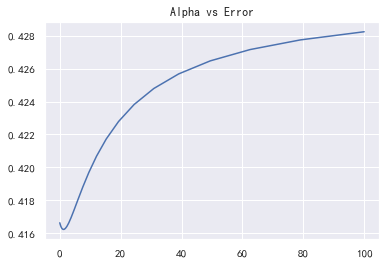

In [20]:
plt.plot(alphas,test_scores)
plt.title('Alpha vs Error')

In [21]:
from sklearn.ensemble import RandomForestRegressor

E:\anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [22]:
N_estimators = [20,50,100,150,200,260,300]
test_scores = []
for N in N_estimators:
    clf=RandomForestRegressor(n_estimators=N,max_features = 0.3)
    test_score=np.sqrt(-cross_val_score(clf,X_train,y_train,cv=5,scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

Text(0.5,1,'N_estimators vs Error')

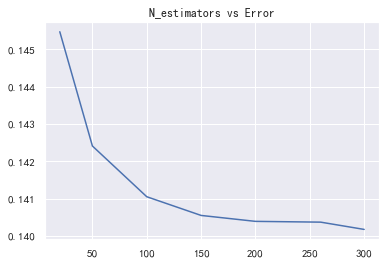

In [23]:
plt.plot(N_estimators, test_scores)
plt.title("N_estimators vs Error")

In [25]:
ridge = Ridge(alpha = 1)
rf = RandomForestRegressor(n_estimators=300,max_features=0.3)
ridge.fit(X_train,y_train)
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.3, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [31]:
print(train_df.shape)

(196539, 10)


In [32]:
print(test_df.shape)

(56279, 10)


In [38]:
test_df.head()


,小区名,小区房屋出租数量,楼层,总楼层,房屋面积,卧室数量,厅的数量,卫的数量,区,位置
0,6011,0.382812,1,0.600000,0.007117,2,1,1,11.0,118.0
1,1697,0.152344,1,0.472727,0.007448,2,1,1,10.0,100.0
2,754,0.207031,2,0.709091,0.014068,3,2,2,12.0,130.0
3,1285,0.011719,0,0.090909,0.008937,2,1,1,7.0,90.0
4,4984,0.035156,1,0.218182,0.008606,2,1,1,3.0,31.0


In [42]:
#ridge_predict=ridge.predict(X_test)
#rf_predict=rf.predict(X_test)
test_score=rf.score(X_train,y_train)
print(test_score)
#y_ridge=np.expml(ridge_predict)
#y_rf=np.expml(rf_predict)

0.9822273217480183


In [ ]:
y_final=(y_ridge+y_rf)/2

In [ ]:
#创建一个空的DataFrame
alist=test['id']
blist=['price']
df=pd.DataFrame(Y_final,index=alist,columns=blist)
print(df)
df.to_csv('pred_4.csv')